# ArviZ


In [1]:
!pip install arviz
!pip install pymc3

In [2]:
import arviz as az
print("arviz version=", az.__version__)
import numpy as np
print("numpy version=", np.__version__)
import pymc3 as pm
print("pymc3 version=", pm.__version__)

arviz version= 0.12.1
numpy version= 1.22.1


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc3 version= 3.11.5


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## ArviZ quickstart

https://python.arviz.org/en/latest/getting_started/Introduction.html

From https://python.arviz.org/en/latest/getting_started/Introduction.html

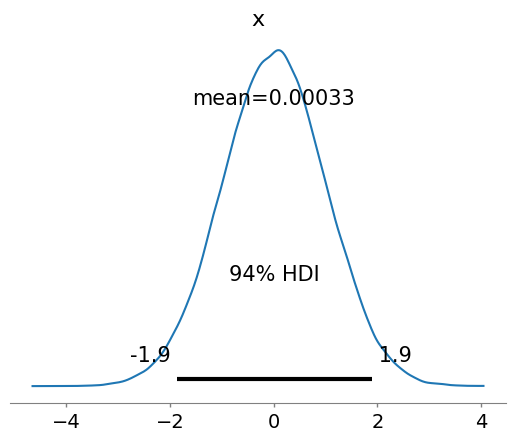

In [4]:
vals = np.random.randn(100_000)
az.plot_posterior(vals);

In [5]:
# A 2d array is interpreted as chain x draws.
# 10 chains, 50 draws.
size = (10, 50)
np.random.randn(*size)

array([[-5.42146286e-01,  1.08987992e+00, -1.08128469e+00,
         5.14688044e-01, -2.54338606e-01,  8.99949318e-03,
        -1.65870966e+00, -2.19927696e+00, -8.06949686e-02,
         6.97163426e-01,  6.81739184e-01, -2.39977910e-02,
        -2.21539018e-01,  1.67329952e-02,  1.16359663e+00,
         1.29919096e+00,  1.38169057e+00, -1.09013249e+00,
        -5.73810416e-01,  7.17582625e-01,  1.27188100e+00,
         1.71278108e-01,  2.04204630e+00,  1.14948773e+00,
        -1.01509893e+00,  1.11418475e+00, -7.26972258e-01,
         2.00770693e+00,  1.10570757e+00,  6.63749144e-01,
         2.07202426e+00, -1.17904371e-01, -2.61927370e-03,
        -1.28986304e+00, -5.83389167e-01, -1.70146495e-01,
         1.41804955e+00,  8.73585365e-01, -3.78882935e-01,
         1.60978710e+00, -1.23415867e+00,  4.68180046e-01,
        -1.86397902e+00, -7.00247928e-01, -2.23956385e+00,
        -3.80482737e-01, -1.12782129e+00, -3.64189396e-01,
         1.05360504e-01,  2.58884443e-01],
       [ 1.20

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

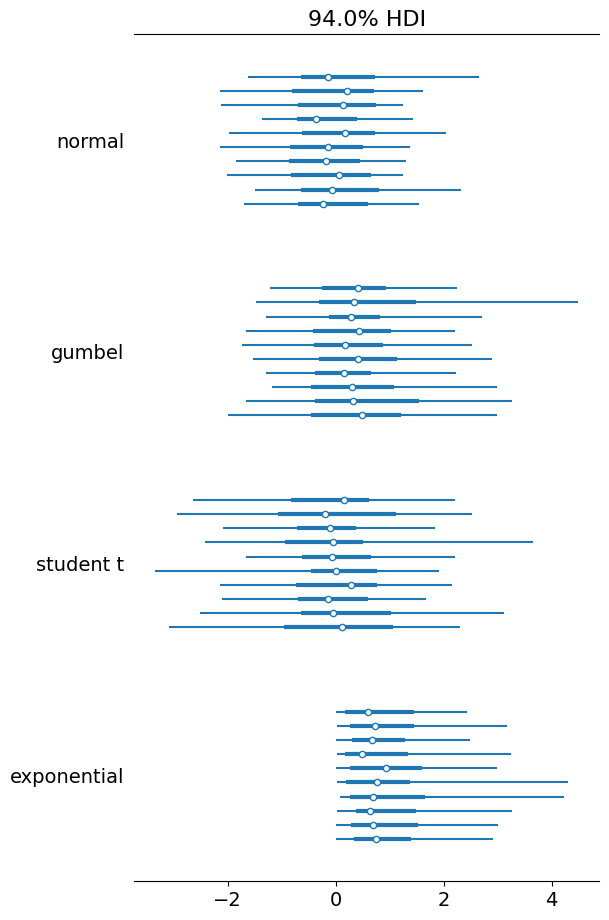

In [6]:
size = (10, 50)
# A dict is interpreted as multiple random vars.
data = {
    "normal": np.random.randn(*size),
    "gumbel": np.random.gumbel(size=size),
    "student t": np.random.standard_t(df=6, size=size),
    "exponential": np.random.exponential(size=size)
}
az.plot_forest(data)

<Axes: title={'center': 'x'}>

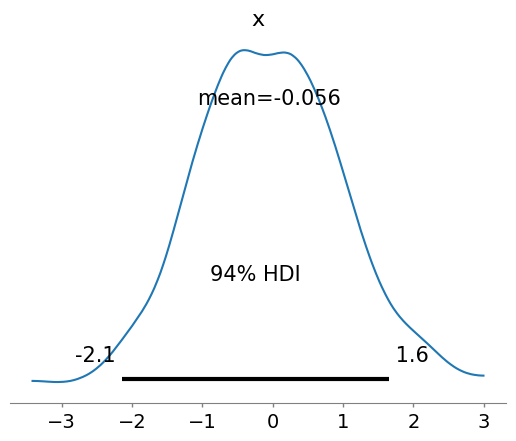

In [7]:
# All the data is concat.
az.plot_posterior(data["normal"])

## InferenceData

In [8]:
import pymc3 as pm

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
schools = np.array([
    "Choate",
    "Deerfield",
    "Phillips Andover",
    "Phillips Exeter",
    "Hotchkiss",
    "Lawrenceville",
    "St. Paul's",
    "Mt. Hermon",
])

with pm.Model() as centered_eight:
    # 8 normal RVs for the mean.
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sd=tau, shape=J)
    # The observed data has random means and known std dev.
    obs = pm.Normal("obs", mu=theta, sd=sigma, observed=y)

    # This pattern is useful in PyMC3.
    prior = pm.sample_prior_predictive()
    centered_eight_trace = pm.sample(return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5605345048206134, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.714293965094562, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


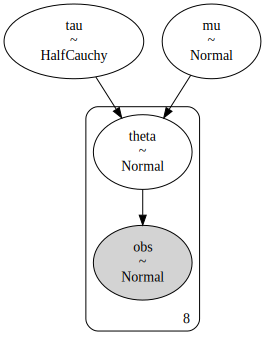

In [10]:
pm.model_to_graphviz(centered_eight)

- Most ArviZ functions accept `trace` objects.
- It can be converted into `InferenceData`

In [15]:
print(type(centered_eight))
print(centered_eight)

print(type(centered_eight_trace))
print(centered_eight_trace)

<class 'pymc3.model.Model'>
       mu ~ Normal
tau_log__ ~ TransformedDistribution
    theta ~ Normal
      tau ~ HalfCauchy
      obs ~ Normal
<class 'pymc3.backends.base.MultiTrace'>
<MultiTrace: 2 chains, 1000 iterations, 4 variables>


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


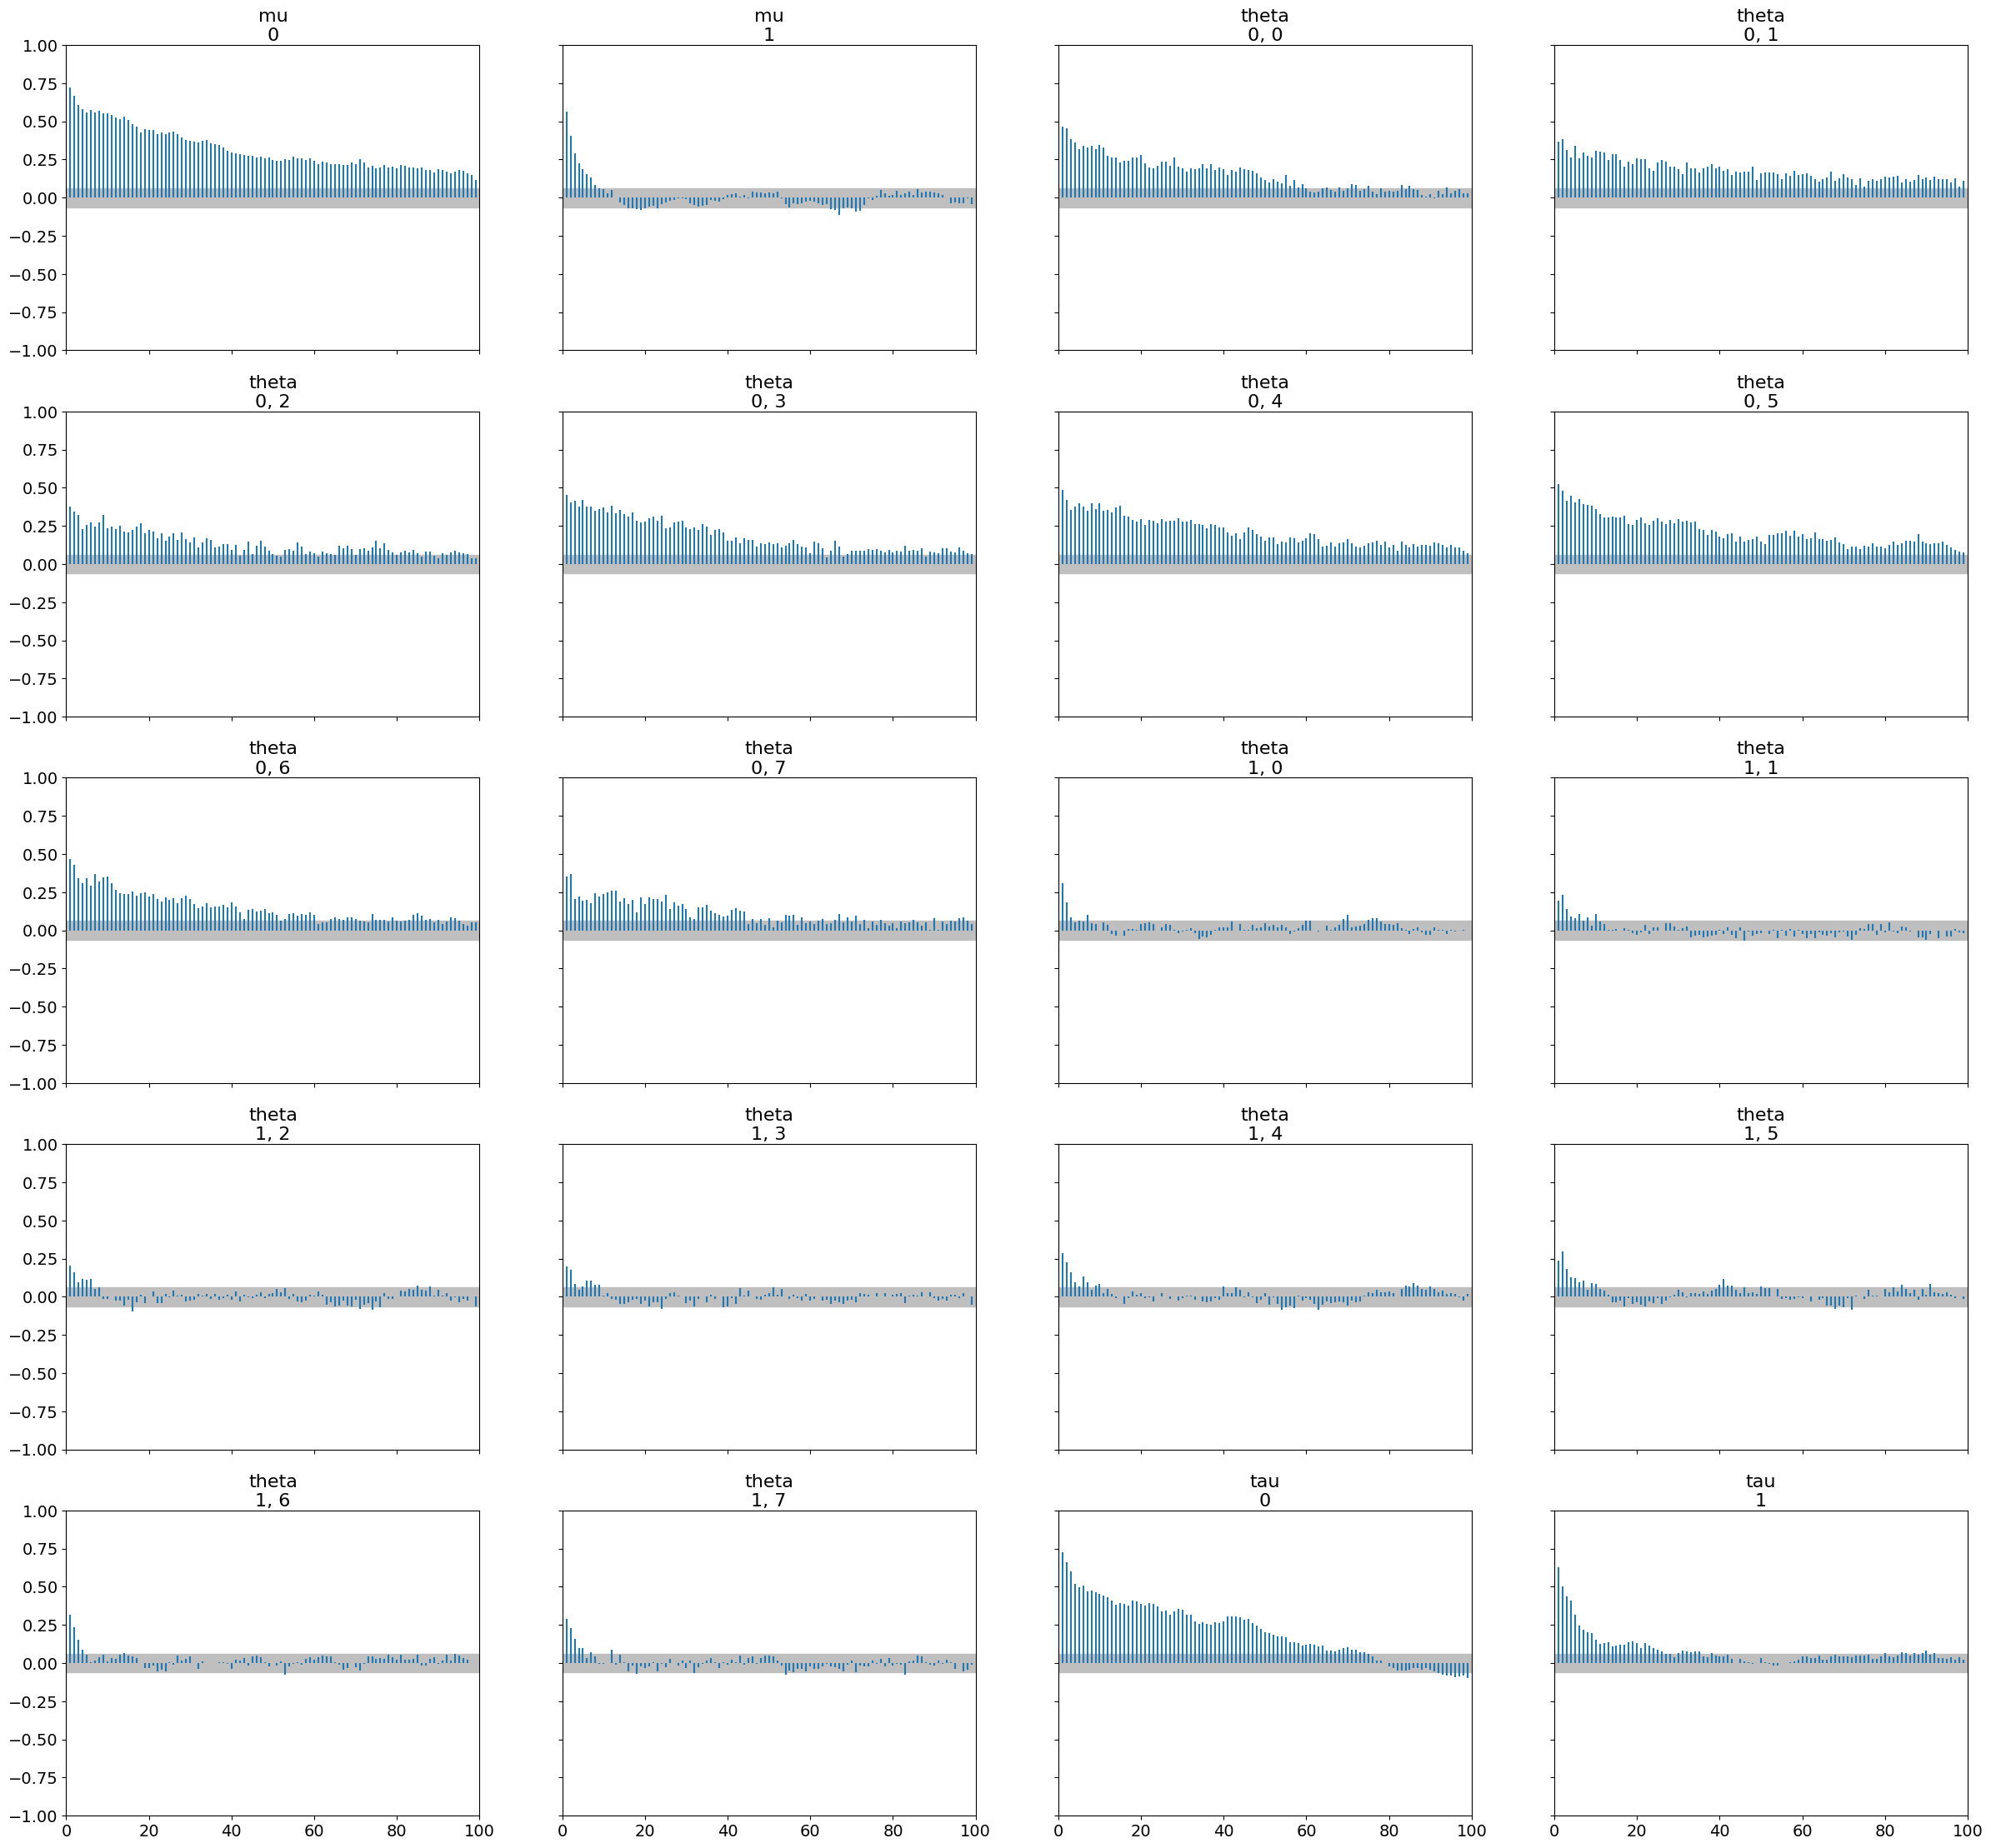

In [17]:
az.plot_autocorr(centered_eight_trace);

In [18]:
data = az.from_pymc3(
    trace=centered_eight_trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=centered_eight,
    coords={"school": schools},
    dims={"theta": ["school"], "obs": ["school"]},
)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data